In [ ]:
from google.colab import files
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Resizing, Rescaling, InputLayer, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load dataset from Kaggle

In [ ]:
!pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"longdc12042000","key":"9e0c1b5b7225689c2ae69ce39783b858"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 612M/612M [00:27<00:00, 23.6MB/s]
100% 612M/612M [00:27<00:00, 23.3MB/s]


In [ ]:
!unzip -q /content/gtsrb-german-traffic-sign.zip

# Data preparation

In [ ]:
path = "/content/Train"

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = path,
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (30, 30),
    seed = 123,
    validation_split=0.2,
    subset='training'
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
  directory = path,
  label_mode = 'categorical',
  color_mode = 'rgb',
  batch_size = 32,
  image_size = (30, 30),
  seed = 123,
  validation_split=0.2,
  subset="validation",
)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
train_dataset = (train_dataset.prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

# Dataset visualization

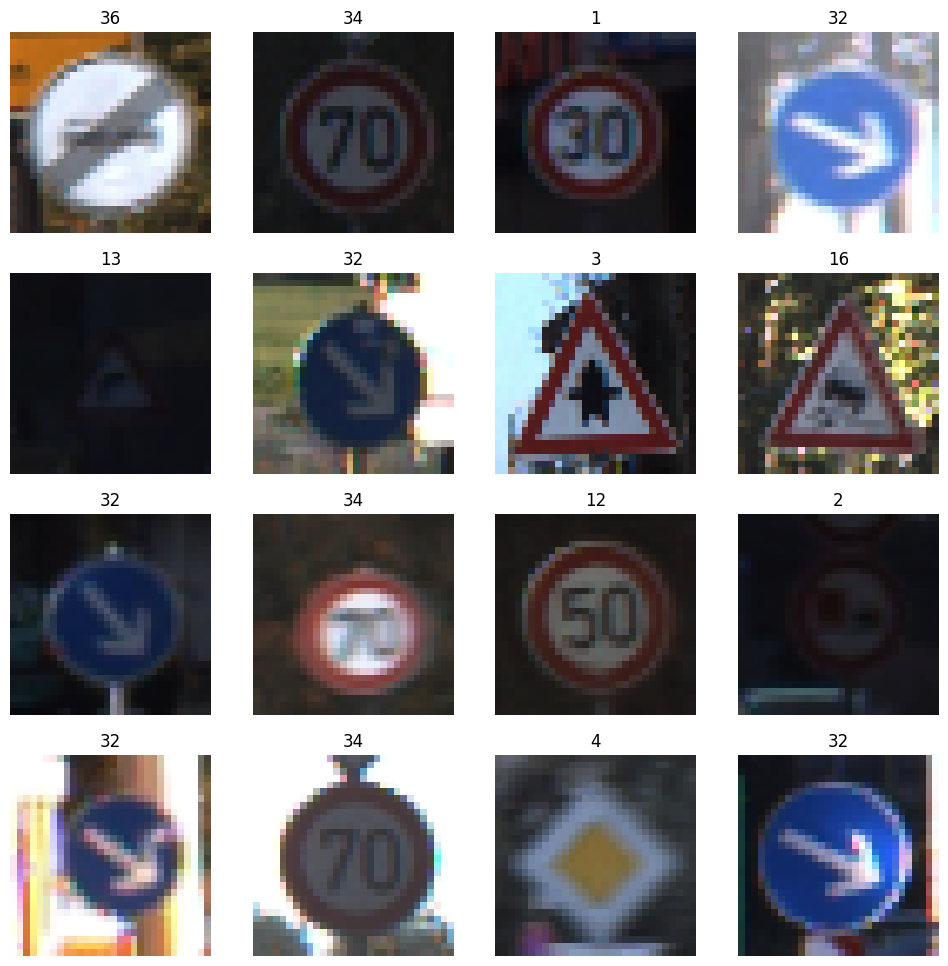

In [ ]:
plt.figure(figsize = (12, 12))

for image, label in train_dataset.take(4):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255)
    plt.title(np.argmax(label[i].numpy()))
    plt.axis("off")

# Setup Learning rate

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5,
                              min_delta=0.005,
                              patience=5, min_lr=0.00001)

# Early Stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_accuracy',
                              min_delta=0,
                              patience=10,
                              verbose=1,
                              mode='auto',
                              restore_best_weights=True,
)

# Callback

In [ ]:
callbacks = [reduce_lr, early_stopping]

# Build model

In [ ]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(30, 30),
    Rescaling(1./255)
])

In [ ]:
my_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,

    Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(rate=0.25),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(rate=0.25),

    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(rate=0.5),
    Dense(43, activation='softmax')
])

my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(my_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 30, 30, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        2432      
                                                                 
 batch_normalization_3 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 11, 11, 32)       

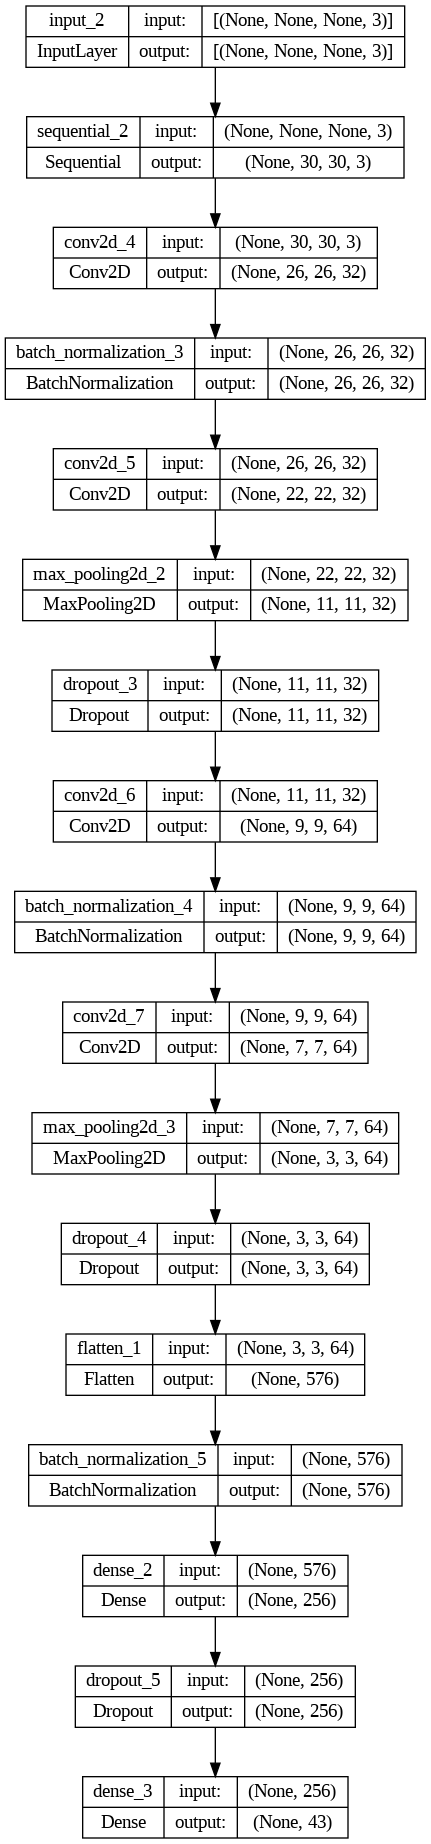

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(my_model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

# Train model

In [ ]:
epochs = 15
history = my_model.fit(train_dataset, batch_size=32, epochs=epochs, validation_data=val_dataset, callbacks=[callbacks])

Epoch 1/15
981/981 [==============================] - 16s 14ms/step - loss: 0.9284 - accuracy: 0.7478 - val_loss: 0.1476 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 2/15
981/981 [==============================] - 14s 14ms/step - loss: 0.1865 - accuracy: 0.9433 - val_loss: 0.0524 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 3/15
981/981 [==============================] - 13s 13ms/step - loss: 0.1186 - accuracy: 0.9627 - val_loss: 0.0315 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 4/15
981/981 [==============================] - 14s 14ms/step - loss: 0.1051 - accuracy: 0.9683 - val_loss: 0.0316 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 5/15
981/981 [==============================] - 15s 16ms/step - loss: 0.0864 - accuracy: 0.9730 - val_loss: 0.0247 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 6/15
981/981 [==============================] - 13s 13ms/step - loss: 0.0912 - accuracy: 0.9725 - val_loss: 0.0369 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 7/15
981/981 [==============================] - 13s 

# Evaluate Model

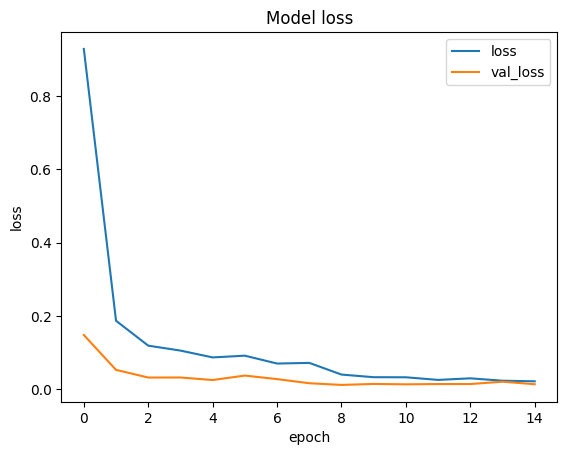

In [ ]:
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

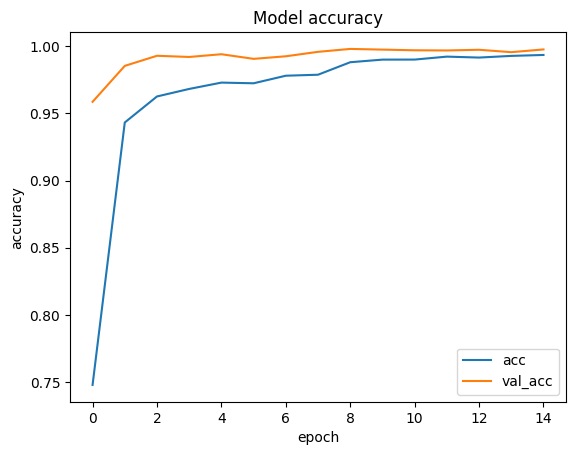

In [ ]:
plt.plot(history.history["accuracy"], label='acc')
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Confusion Matrix

## Confusion matrix

In [ ]:
labels = []
predicted = []
for im, label in val_dataset:
  labels.append(label.numpy())
  predicted.append(my_model(im))

In [ ]:
print(np.argmax(labels[:-1], axis = -1).flatten())
print(np.argmax(predicted[:-1], axis = -1).flatten())

[12 29 34 ...  5  9  5]
[12 29 34 ...  5  9  5]


In [ ]:
pred = np.argmax(predicted[:-1], axis = -1).flatten()
label = np.argmax(labels[:-1], axis = -1).flatten()

Text(0.5, 146.7222222222222, 'Predicted')

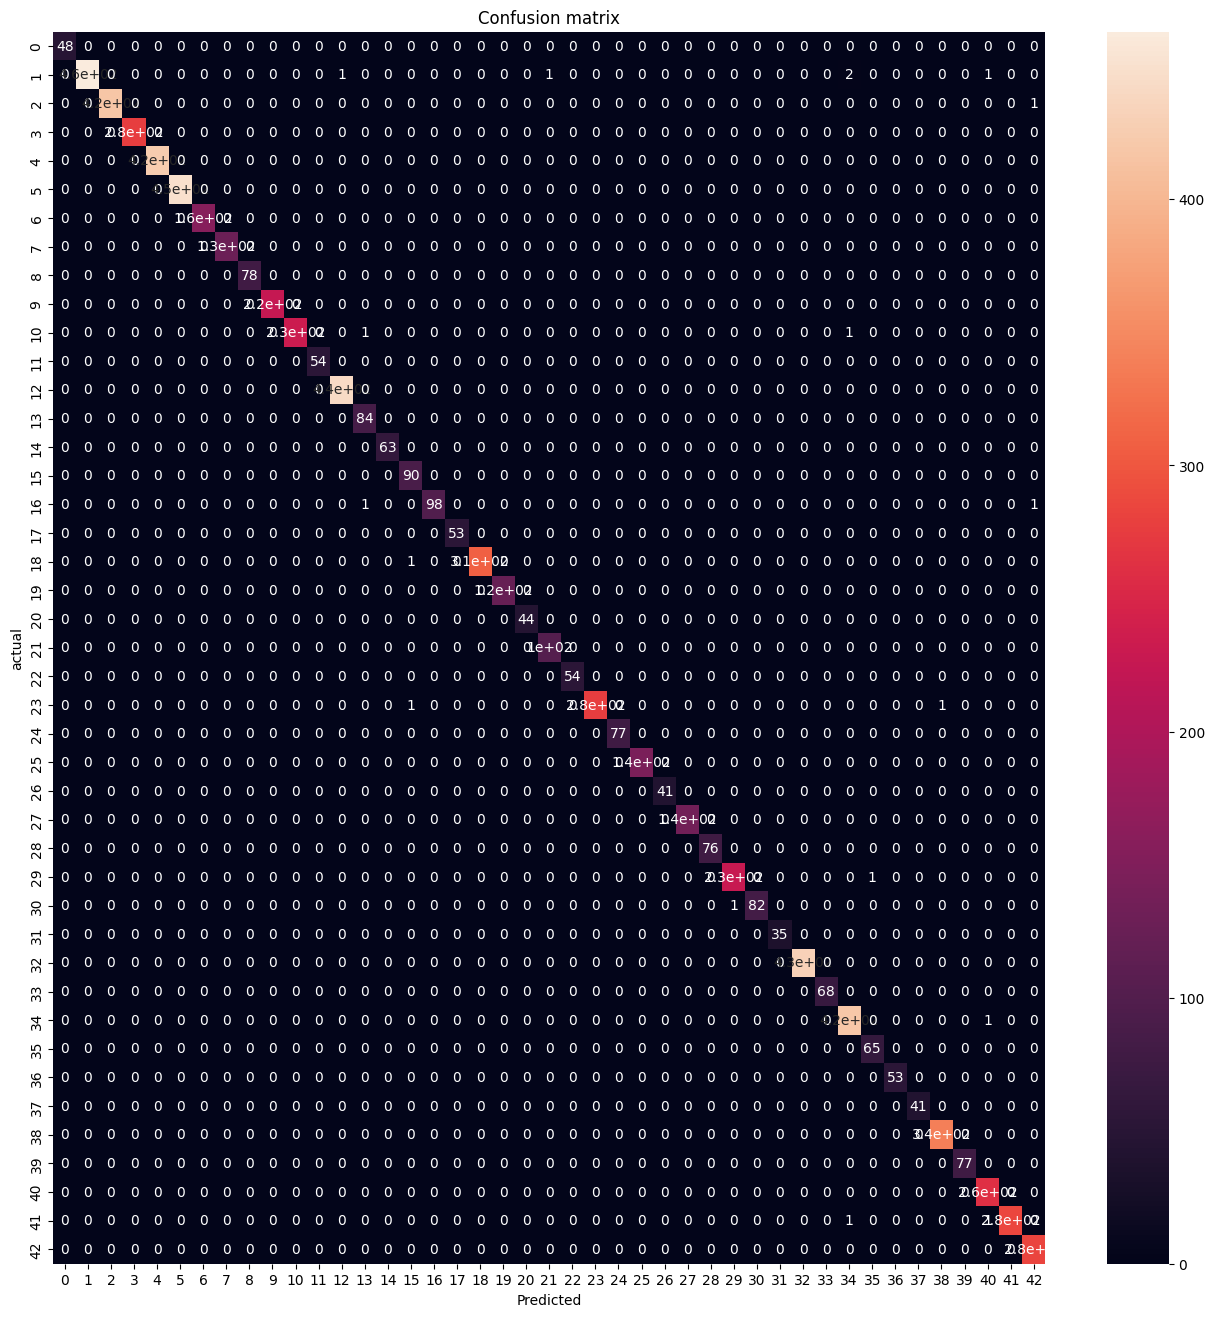

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label, pred)
plt.figure(figsize=(16, 16))

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')
plt.ylabel("actual")
plt.xlabel("Predicted")

#Testing

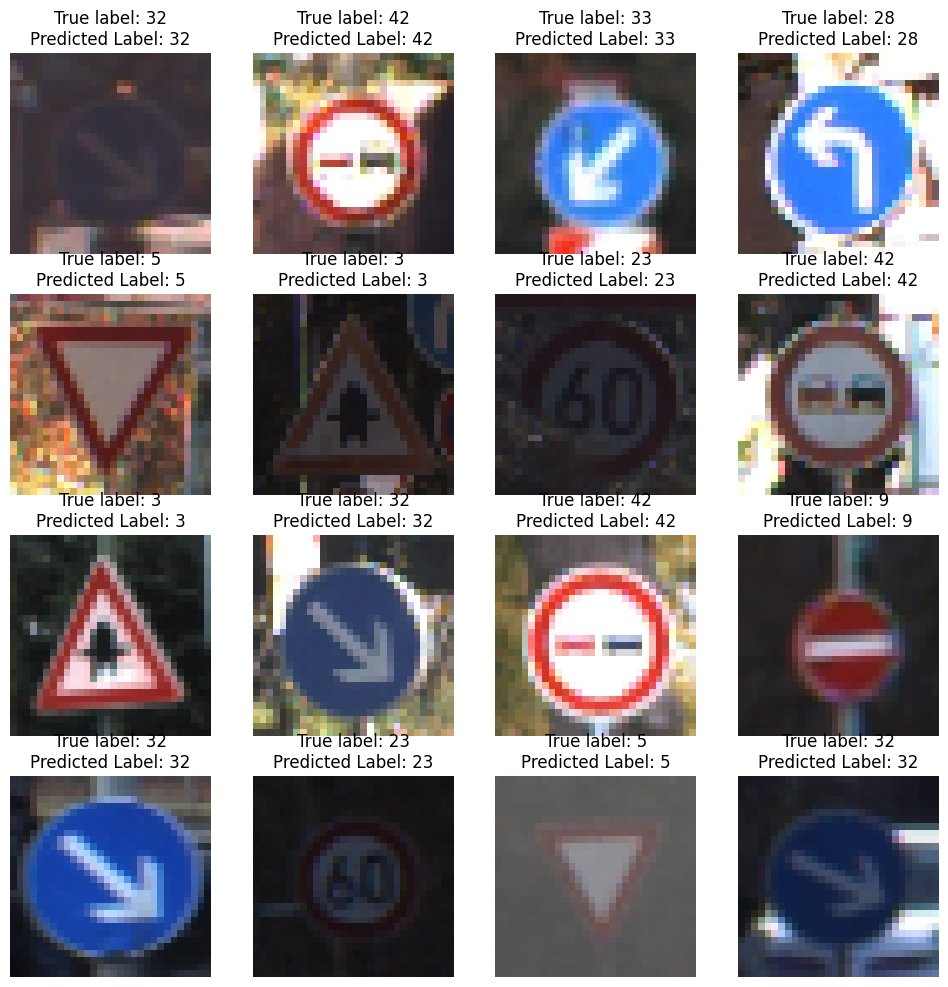

In [ ]:
plt.figure(figsize = (12, 12))

for image, label in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255)
    plt.title("True label: " + str(tf.argmax(label[i], axis=0).numpy()) + "\n" + "Predicted Label: " + str(tf.argmax(my_model(tf.expand_dims(image[i], axis = 0)), axis= -1).numpy()[0]))
    plt.axis("off")

# Save model

In [ ]:
my_model.save('model.h5')

In [ ]:
my_model.save('my_model')